In [2]:
!pip install h5py

You are using pip version 10.0.1, however version 18.0 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


/home/jericho/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in log
/home/jericho/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:109: RuntimeWarning: invalid value encountered in log


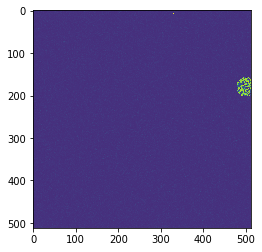

In [9]:
from __future__ import print_function, division, absolute_import, unicode_literals
%matplotlib inline

import numpy as np
import random
import math
import pickle
import os
import h5py
import matlab.engine
from scipy.io import loadmat
import matplotlib.pyplot as plt

sigma = 10

plateau_min = -2
plateau_max = 2

r_min = 1
r_max = 200

width = 512
height = 512
cnt1 = 1
cnt2 = 30

nbins = 4
image = np.zeros((width, height, nbins))
labels = np.zeros([width, height], dtype=np.bool)

imgx, imgy = width, height
nx = []  # hold the x value
ny = []  # holds the y value
nr = np.zeros([nbins, int(cnt2)])  # low energy image
nr2 = np.zeros([nbins, int(cnt1)])  # high energy image
label = []  # labels whether or not the cell has cartilage

target_SNR = 100
# Finding the singnal in water that will be the basis for the noise
signal = 3.1109 * 10**3
# Finding the target noise
sigma = signal / target_SNR
# Finding the signal strength that would give the correct poisson noise
correct_signal = (signal / sigma)**2.

D = loadmat(
    "/home/jericho/Downloads/bin/pcd_planar_imaging/DES_radiography/DES_3.0/Y_ML_val.mat"
)

cal_values = D["Y_ML_val"][:, 1:]

inds_0 = np.where(cal_values[0, :] == 0)[0]
inds_1 = np.where(cal_values[0, :] != 0)[0]

for i in range(int(cnt2)):

    # choosing random place for the cell
    nx.append(random.randrange(imgx))
    ny.append(random.randrange(imgy))
    pp = random.randint(0, len(cal_values[cal_values == 0.]) - 1)

    # making a random value for the cartilage
    #     if i % 2 == 0:
    #         nr[:, i] = cal_values[1:5, rr]
    #         label.append(1)
    #     else:
    nr[:, i] = cal_values[1:5, inds_0[pp]]
    label.append(0)

for y in range(imgy):
    for x in range(imgx):
        dmin = math.hypot(imgx - 1, imgy - 1)
        j = -1
        for i in range(int(num_cells / 2 - 20)):
            d = math.hypot(nx[i] - x, ny[i] - y)
            if d < dmin:
                dmin = d
                j = i

        # Generating some poisson noise\
        #for kk in range(nbins):
        image[x, y, :] = np.nan_to_num(np.log(
            (np.exp(nr[:, j])) +
            np.random.normal(0, np.sqrt(np.exp(nr[:, j]) * 2500)) / 2500))

labels[x, y] = label[j]

r_min = 3
r_max = 50
border = 10
sigma = 10

#image = np.ones((nx, ny, 1))
label = np.ones((width, height))
mask = np.zeros([width, height], dtype=np.bool)
for i in range(int(cnt1)):
    a = np.random.randint(border, width - border)
    b = np.random.randint(border, height - border)
    r = np.random.randint(r_min, r_max)
    rr = random.randint(0, len(inds_1) - 1)
    nr2[:, i] = cal_values[1:5, inds_1[rr]]

    y, x = np.ogrid[-a:width - a, -b:height - b]
    m = x * x + y * y <= r * r
    mask = np.logical_or(mask, m)

    image[m] = np.nan_to_num(
        np.log((np.exp(nr2[:, i])) + np.random.normal(
            0, np.sqrt(np.exp(nr2[:, i]) * 2500), size=image.shape)[m] / 2500))

labels[mask] = 1

matlab_reshape = np.reshape(image,[image.size],order='F').copy()
matlab_reshape = list(np.squeeze(matlab_reshape)).copy()
matlab_reshape = matlab.double(matlab_reshape)

eng = matlab.engine.start_matlab()
ys = eng.net_val(matlab_reshape)

image = np.zeros((width,height,1))
image[:,:,0] = np.reshape(ys,[width,height],order='F').copy()

image -= np.amin(image)
image /= np.amax(image)
    
plt.figure()
plt.imshow(image[:,:,0])


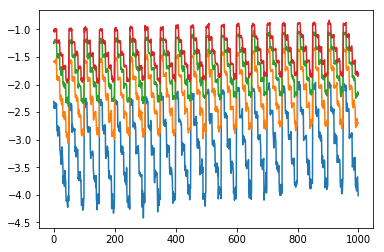

In [8]:
plt.figure()
plt.plot(x.T)

In [7]:
x = np.log(ML_vec[0:4,:]/2500)
t = ML_vec[4,:]

In [9]:
matlab_reshape = np.reshape(x,[x.size],order='F').copy()
# import scipy.io as sio
# sio.savemat("ML_vec2.mat", {"matlab_reshape":matlab_reshape})
matlab_reshape = list(np.squeeze(matlab_reshape))
matlab_reshape = matlab.double(matlab_reshape)


eng = matlab.engine.start_matlab()

perf = eng.net_cal(matlab_reshape,matlab.double(list(t)),nargout = 1)
print(perf["perf"])
ys = eng.net_val(matlab_reshape)

[[6.9995443084071445,1.8606536585599533,1.7768402147092832,1.6852787867322763,1.6141653202226514,1.6028208478583545,1.597047925832662,1.5947525264268845,1.5929486169249296,1.591449288853591,1.5899978879519177,1.5885283055003976]]


In [10]:
#ray tracer for the calibration step

%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import random
import math
import pickle
import os
import matlab.engine
from scipy.interpolate import interp1d

from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.optimizers import Adam, SGD
import keras.optimizers as opti

bin_vector= [16,30.8,37.5,45,60]
#bin_vector= [16,37.5,60]
#bin_vector = [16,60]
#bin_vector = [58,60]

# Modified these paths
script_dir = os.path.dirname(os.getcwd()) #<-- absolute dir the script is in
rel_path = 'tf_unet/Attenuation_with_air_0_1.pkl'
abs_file_path = os.path.join(script_dir, rel_path)

# This is the part that imports the files
with open(abs_file_path,'rb') as f:  # Python 3: open(..., 'rb')
    Attenuation, Attenuation2, Spec, Air = pickle.load(f)
Ev = Spec[:,0]
Int = Spec[:,1]
#Int = Int*10000/sum(Int)

f4 = interp1d(Ev,Int,kind='quadratic')
Ev_long = np.linspace(Ev[0],Ev[-1],len(Ev)*5 - 4)
Int_long = f4(Ev_long)

#inds = Ev%1 == 0

Int_long = Int
Ev_long = Ev

Int_long = Int_long*10000/sum(Int_long)
#Convert the bin vector from energies to indices
nbins = len(bin_vector)-1

for ii in range(nbins+1):
    bin_vector[ii] = min(range(len(Ev_long)), key=lambda i: abs(Ev_long[i]-bin_vector[ii]))

Int_long = Int_long*10000/sum(Int_long)
pixel_value = 0.

total_intensities = []
for ii in range(len(bin_vector)-1):
    total_intensities.append(sum(Int_long[bin_vector[ii]:bin_vector[ii+1]]))
    
# hard coding a start to avoid the k edges
f1 = interp1d(np.log(Attenuation[12:,0]),np.log(Attenuation[12:,6]))#,kind='quadratic')
f2 = interp1d(np.log(Attenuation2[19:,0]),np.log(Attenuation2[19:,6]))#,kind='quadratic')
f3 = interp1d(np.log(Air[:,0]),np.log(Air[:,6]))#,kind='quadratic')

# plt.figure()
# plt.plot(np.log(Attenuation[12:,0]),np.log(Attenuation[12:,6]))
# plt.plot(np.log(Attenuation2[19:,0]),np.log(Attenuation2[19:,6]))
# plt.plot(np.log(Ev_long/1000.),np.log(Int_long),'b*')

chebs = 1.9*np.cos((2.*np.arange(0,20))*np.pi/36.) + 2.1

target_SNR = 10
# Finding the singnal in water that will be the basis for the noise
signal = 3.1459*10**3
# Finding the target noise
sigma = signal / target_SNR
# Finding the signal strength that would give the correct poisson noise
correct_signal = (signal / sigma)**2.

# Now we need to scale the image by the correct factor so that the sqrt
# of the image is the noise

n_sample = 10
nps = len(chebs)
ML_vec = np.zeros([5,nps*n_sample*5])
ML_label = np.zeros([nps*5*n_sample])

n_sample = 10
nps = len(np.linspace(2,4,10))
ML_vec = np.zeros([4,nps*n_sample*3])
ML_label = np.zeros([nps*3*n_sample])

count = -1
nbins  = 4
for kk,t_cart in enumerate(np.linspace(2,4,10)):
    for ll,t_total in enumerate([6,7,8]):
        count += 1
        ML_label[count*n_sample:count*n_sample+n_sample] = np.ones([1,n_sample])*t_cart
        for jj in range(nbins): 
        # finding the attenuation for the low image
            for ii,energy in enumerate(Ev_long[bin_vector[jj]:bin_vector[jj+1]]):
                mu = f1(np.log(energy/1000.))
                mu2 = f2(np.log(energy/1000.))
                mu_air = f3(np.log(energy/1000.))
                mu = np.exp(mu)
                mu2 = np.exp(mu2)
                mu_air = np.exp(mu_air)

#                 plt.figure(1)
#                 plt.plot(np.log(energy/1000.),np.log(mu),'r*')

                #mu = 0.2073
                # wrong density of water to match the image
        
                t_water = t_total - t_cart
                pixel_value += (Int_long[ii+bin_vector[jj]]*np.exp(-mu*t_water*1.015)
                             *np.exp(-mu2*t_cart*1.1)*np.exp(-mu_air*30*0.00120479))

#                 plt.figure(2)
#                 plt.plot(ii,pixel_value,'k*')

            #print(pixel_value)

            temp_ML_vec = pixel_value + np.random.normal(0, np.sqrt(pixel_value*.4), n_sample) #*correct_signal / signal + np.random.normal(0, np.sqrt(pixel_value*correct_signal/signal), n_sample)
            ML_vec[jj,count*n_sample:count*n_sample+n_sample]= temp_ML_vec
        
            pixel_value = 0.

In [11]:
ML_vec = np.log(ML_vec/2500.)
matlab_reshape = np.reshape(ML_vec,[ML_vec.size],order='F').copy()
# import scipy.io as sio
# sio.savemat("ML_vec2.mat", {"matlab_reshape":matlab_reshape})
matlab_reshape = list(np.squeeze(matlab_reshape))
matlab_reshape = matlab.double(matlab_reshape)


eng = matlab.engine.start_matlab()

ys = eng.net_val(matlab_reshape)
mse = np.nanmean((ML_label - ys)**2)
print(mse)

7.053586603796012


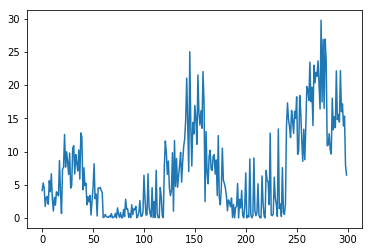

In [12]:
P =np.asarray(ML_label - ys)**2
plt.figure()
plt.plot(P.T)

In [70]:
print(ML_vec[1,1:100])
NS = np.std(np.sum(ML_vec[:,1:100],axis=0))
SIG = np.mean(ML_vec[1,1:100])
print(SIG/NS)

[295.81253609 295.81253609 295.81253609 295.81253609 295.81253609
 295.81253609 295.81253609 295.81253609 295.81253609 212.76229658
 212.76229658 212.76229658 212.76229658 212.76229658 212.76229658
 212.76229658 212.76229658 212.76229658 212.76229658 153.10182632
 153.10182632 153.10182632 153.10182632 153.10182632 153.10182632
 153.10182632 153.10182632 153.10182632 153.10182632 292.28912331
 292.28912331 292.28912331 292.28912331 292.28912331 292.28912331
 292.28912331 292.28912331 292.28912331 292.28912331 210.23400498
 210.23400498 210.23400498 210.23400498 210.23400498 210.23400498
 210.23400498 210.23400498 210.23400498 210.23400498 151.28671001
 151.28671001 151.28671001 151.28671001 151.28671001 151.28671001
 151.28671001 151.28671001 151.28671001 151.28671001 288.80815579
 288.80815579 288.80815579 288.80815579 288.80815579 288.80815579
 288.80815579 288.80815579 288.80815579 288.80815579 207.73609848
 207.73609848 207.73609848 207.73609848 207.73609848 207.73609848
 207.73609

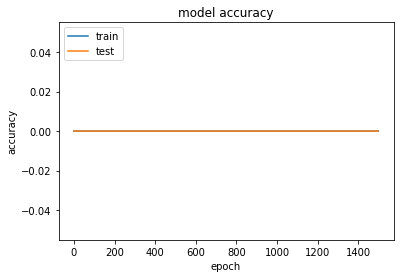

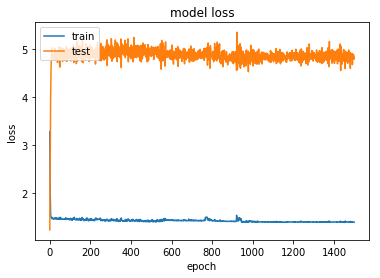

In [54]:
# Create a model with one hidden layer, just like in Matlab

model = Sequential()
model.add(Dense(33, input_shape=(4,)))
model.add(Activation('tanh'))
model.add(Dense(1))
model.add(Activation('linear'))

opti = Adam()

model.compile(optimizer=opti,
              loss='mean_squared_error', metrics=['accuracy'])

# Train the model

history = model.fit(ML_vec.transpose(), ML_label, epochs=1500, validation_split=0.15, verbose=0)

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

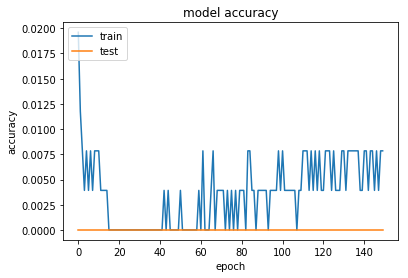

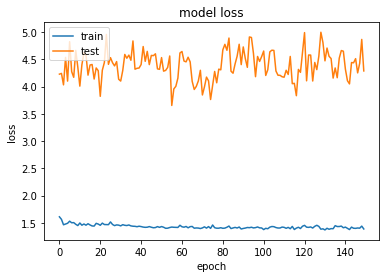

In [63]:
# create model
model = Sequential()
model.add(Dense(33, input_shape=(4,)))
model.add(Activation('tanh'))
model.add(Dense(1))
model.add(Activation('linear'))

sgd = SGD(lr=0.0001, decay=1e-7, momentum=0.1, nesterov=True)
RMS = opti.RMSprop(lr=0.001, rho=0.9, epsilon=None, decay=0.0)
model.compile(loss='mean_squared_error', optimizer=RMS, metrics=['accuracy'])

# Fit the model
history = model.fit(ML_vec.transpose(), ML_label, validation_split=0.15, epochs=150, batch_size=10, verbose=0)

# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

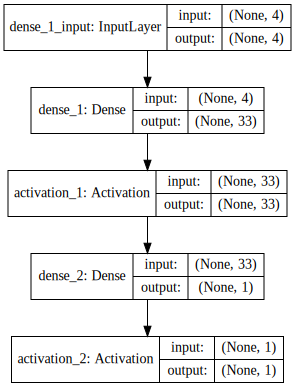

In [5]:
%matplotlib inline
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model,show_shapes='True').create(prog='dot', format='svg'))